# Tarea 4 - LTE opacities for a pure H atmosphere

We try to reproduce Figure 8.5 a, b, c, d from Gray, which show the wavelength-dependent continuous absorption coefficient $\kappa_\lambda$ for different temperatures $T$ and electron pressures $P_e$.  For simplicity, we consider only hydrogen, in the form of the neutral atom and the positive and negative ions.  Ion fractions and excitation of bound levels is calculated under the assumption of local thermodynamic equilibrium. 

In [121]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context='notebook', 
        style='whitegrid', 
        palette='dark',
        font_scale=1.5,
        color_codes=True)

/Users/will/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Set up the constants we need

In [78]:
import astropy.units as u
from astropy.constants import k_B, c, h, m_p
from astropy.table import Table, Column

We work with all energies in electron volts. We define the constants as pure numbers because it doesn't seem possible to use `astropy.units` quantities with vectorized functions.

In [55]:
BOLTZMANN = k_B.to(u.eV/u.K).value
PLANCK = h.to(u.eV*u.s).value
RYDBERG = (13.6*u.eV).value
HMINUS_EION = (0.754*u.eV).value

print('BOLTZMANN =', BOLTZMANN, 'eV/K')
print('PLANCK =', PLANCK, 'eV.s')
print('RYDBERG =', RYDBERG, 'eV')
print('HMINUS_EION =', HMINUS_EION, 'eV')

BOLTZMANN = 8.617332384960955e-05 eV/K
PLANCK = 4.1356675130246955e-15 eV.s
RYDBERG = 13.6 eV
HMINUS_EION = 0.754 eV


## Ionization balance of hydrogen

### The general Saha equation

We use the following version of the Saha equation:
$$
\frac{N_{j+1} N_e}{N_j} = \Phi_j(T), 
$$
which relates the densities of adjacent ionization stages $j$ and $j+1$. 

First define the $T$-dependent function $\Phi_j = 4.8293744908\times 10^{15} \left(U_{j+1}/U_j\right) T^{1.5} e^{-E_j/k T}$, where $E_i$ is the ionization potential of ion $j$ and $U_j$, $U_{j+1}$ are the partition functions.

In [57]:
def Saha_Phi(T, Eion=1.0*RYDBERG, Ui=2.0, Un=2.0):
    """
    Función Phi(T) = (Ni Ne / Nn) de Saha 
    para energía de ionización Eion,
    y con funciones de partición Ui y Un
    """
    return 4.8293744908e15 * (Ui/Un) * T**1.5 * np.exp(-Eion/(BOLTZMANN*T))


Test the function for some typical temperatures.  

In [67]:
Ts = np.array([3, 5, 9, 15])*u.kK
Ts.cgs

<Quantity [  3000.,  5000.,  9000., 15000.] K>

Note that the `T` argument should be a normal number (e.g, `float`) in units of Kelvin.  In this example, we set up the temperature array in kilo-Kelvin, so we need to convert to cgs (or SI) and take the `value` before sending it to the function.  

In [68]:
Saha_Phi(Ts.cgs.value)

array([  1.12869344e-02,   3.34308817e+07,   9.99054222e+13,
         2.39126892e+17])

### The abundance of the positive hydrogen ion

We assume that the abundance of $H^-$ is always negligible, so that we have equal numbers of protons and free electrons: $N_+ = N_e$. Then the H ionization fraction, $y = N_+ / N_H$ is the solution of the polynomial $y^2 + A y - A = 0$, where $A = \Phi_{H_0} / N_H$. 

We define a function that calculates $y$.  We use the `@np.vectorize` decorator so that we can use it on arrays of density and temperature. This is necessary here since `np.roots` solves only a single polynomial. 

In [59]:
@np.vectorize
def Hplus_fraction(Hden, T):
    """
    Calcular fracción de hidrógeno ionizado
   $$
   	`Hden` es densidad de partículas totales de H en cm^{-3}
    `T` es temperatura en K
    """
    A = Saha_Phi(T) / Hden
    # Resolver polinomio: y**2 + A*y - A = 0
    y = np.roots([1.0, A, -A])[1] # tomar raiz positivo
    return y


### The abundance of the negative hydrogen ion

The Saha equation for H$^-$ is:
$$
\frac{N_{H^0} N_e}{N_{H^-}} = \Phi_{H^-}(T),
$$
from which it follows that 
$$
N_{H^-} \big/ N_H = \left( N_{H^0} \big/ N_H \right) N_e \big/ \Phi_{H^-} = (1 - y) y N_H \big/ \Phi_{H^-}
$$


In [75]:
def Hminus_fraction(Hden, T):
    """
    Calcular fracción del ión negativo de hidrógeno
    """ 
    y = Hplus_fraction(Hden, T)
    return y * (1. - y) * Hden/Saha_Phi(T, Eion=HMINUS_EION, Un=1.0)

### Table and graphs of the ion fractions

Define some typical atmospheric densities.  Then, make a table of the ion fractions four these four densities and the four temperatures that we defined above.

In [81]:
Ns = np.array([10, 3, 1, 0.5])*1e15/u.cm**3
Ns

<Quantity [  1.00000000e+16,  3.00000000e+15,  1.00000000e+15,
             5.00000000e+14] 1 / cm3>

In [82]:
Table(
  data=[
    Column(Ns.cgs, name=r'$N_H$'),
    Column(Ts.cgs, name=r'$T$'),
    Column(Hplus_fraction(Ns.cgs.value, Ts.cgs.value), name=r'$N_+/N_H$'),
    Column(Hminus_fraction(Ns.cgs.value, Ts.cgs.value), name=r'$N_-/N_H$'),
  ])	

$N_H$,$T$,$N_+/N_H$,$N_-/N_H$
1 / cm3,K,,
float64,float64,float64,float64
1e+16,3000.0,1.06239984774e-09,1.23694280086e-13
3e+15,5000.0,0.000105557808511,5.33566452757e-10
1e+15,9000.0,0.270048375654,6.31935080413e-08
5e+14,15000.0,0.99791775855,1.04923060733e-10


Note that the H$^-$ fraction is always very small, which justifies ignoring its effect on the electron density. 

Next, we plot the ion fractions against temperature for a wide range of densities. 

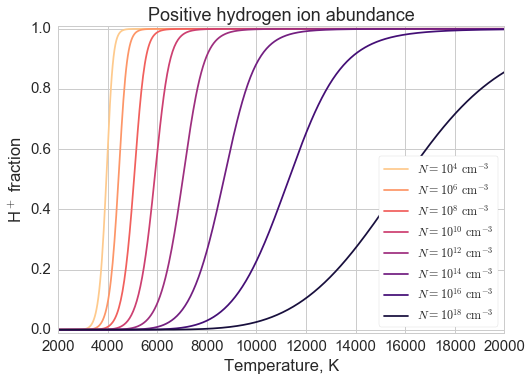

In [127]:
logNgrid = range(4, 20, 2)
Tgrid = np.linspace(2e3, 2e4, 500)
fig, ax = plt.subplots(1, 1)
legend_box_params = {
  'frameon': True,
  'fancybox': True,
  'fontsize': 'large',
}
colors = sns.color_palette('magma_r', n_colors=len(logNgrid))
epsilon = 0.01
for logN, c in zip(logNgrid, colors):
  ax.plot(Tgrid, Hplus_fraction(10**logN, Tgrid), color=c, 
          label=r'$N = 10^{{{}}}\ \mathrm{{cm}}^{{-3}}$'.format(logN))
frame = ax.legend(loc='lower right', **legend_box_params).get_frame()
frame.set_facecolor('white')
ax.set_ylim(-epsilon, 1 + epsilon)
ax.set_title('Positive hydrogen ion abundance')
ax.set_xlabel('Temperature, K')
ax.set_ylabel('H$^+$ fraction');

At the lower densities, hydrogen transitions from almost fully neutral to almost fully ionized over a narrow range of temperatures around 4000 K.  But such lower densities are only seen in the corona, where LTE does not apply.   As the density is increased, higher temperatures are required and the curves shift to the right.  For densities characteristic of stellar photospheres, the transition occurs around 7000 to 10,000 K.

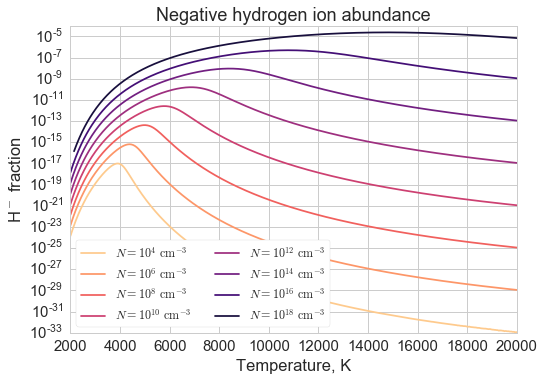

In [128]:
fig, ax = plt.subplots(1, 1)
for logN, c in zip(logNgrid, colors):
  ax.semilogy(Tgrid, Hminus_fraction(10**logN, Tgrid), color=c,
          label=r'$N = 10^{{{}}}\ \mathrm{{cm}}^{{-3}}$'.format(logN))
frame = ax.legend(loc='lower left', ncol=2, **legend_box_params).get_frame()
frame.set_facecolor('white')
ax.set_title('Negative hydrogen ion abundance')
ax.set_xlabel('Temperature, K')
ax.set_ylabel('H$^-$ fraction');

The abundance of negative hydrogen ion is shown on a logarithmic scale.  It generally increases with density, and it has a peak at the temperature where H is about 50% ionized, as can be seen by comparing this graph with the previous one.

## Excitation of bound levels of H$^0$

In [1]:
import lteopacity

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from lteopacity import LIGHTSPEED_CGS, ANGSTROM_CGS, MASA_PROTON
from lteopacity import opacidad_total, funcHden, Hplus_fraction

In [3]:
%matplotlib inline

In [5]:
wav = np.linspace(2500.0, 20000.0, 500)
nu = LIGHTSPEED_CGS / (wav * ANGSTROM_CGS)


In [6]:
# Gray, Fig 8.5a-d
subfig_list = "abcd"
T_list = [5143.0, 6429.0, 7715.0, 11572.0]
logPe_list = [1.08, 1.77, 2.50, 2.76]
for T, logPe, subfig in zip(T_list, logPe_list, subfig_list):
    Pe = 10**logPe
    Hden = funcHden(Pe, T)
    y = Hplus_fraction(Hden, T)
    for label, opacity in opacidad_total(Hden, T, nu).items():
        plt.plot(wav, opacity, label=label)
    plt.title(u"T = %i K, log Pe = %.2f, log Hden = %.2f, H+/H0 = %.2e" % (T, logPe, np.log10(Hden), y))
    plt.xlabel(u"lambda, Å")
    plt.ylabel(u"kappa_nu, unidad = cm^2/g")
    plt.axis([None, None, 0.0, None])
    plt.legend()
    plt.savefig("test_opacity_%s.png" % (subfig))
    plt.clf()

In [71]:
Table?